In [12]:
!git clone https://github.com/alexandermath/fasth
!python -m pip install ninja
%cd fasth
!python test_case.py

Cloning into 'fasth'...
remote: Enumerating objects: 95, done.
remote: Counting objects: 100% (95/95), done.
remote: Compressing objects: 100% (74/74), done.
remote: Total 95 (delta 47), reused 52 (delta 20), pack-reused 0
Unpacking objects: 100% (95/95), done.
/content/fasth/fasth
Compiling our c++/cuda code, this usually takes 1-2 min. 
Finished compilation, took: 67.9213s

---------- Assertions ----------
Multiplication:			PASSED!
Inverse Multiplication: 	PASSED!
Reconstruction: 		PASSED!

---------- Check Orthogonal Inverse ----------
Multiplication:			PASSED!

---------- Time Algorithms ----------
Printing time of both algorithms as [mean +- std]. 
[100 / 100]	Seq: 	[0.050833 +- 0.004547] 	Ours: [0.002958 +- 0.000145] 	 
Speed-up: 	0.050833 / 0.002958 = 17.18 times faster

---------- Time Neural Network ----------
Taking time of a single gradient step for a
Neural Network with orthogonal matrices of size 
[512, 512, 512]. 
Sequential: 	0.4857
Our approach: 	0.0287
Speed-up: 	16.94

In [3]:
%cd exp/

/content/fasth/exp


| dimension  | FastH      | Exp        | Cayley     | Sequential |
| 64         | 0.001355   | 0.006576   | 0.004986   | 0.014196   |
| 128        | 0.002006   | 0.006823   | 0.005234   | 0.032023   |
| 192        | 0.004518   | 0.011100   | 0.009453   | 0.047302   |
| 256        | 0.005067   | 0.012672   | 0.010060   | 0.061217   |
| 320        | 0.005087   | 0.013343   | 0.011257   | 0.075896   |
| 384        | 0.005688   | 0.014628   | 0.012302   | 0.093031   |
| 448        | 0.006195   | 0.016047   | 0.013557   | 0.109005   |
| 512        | 0.006777   | 0.017575   | 0.015604   | 0.120805   |
| 576        | 0.007487   | 0.019245   | 0.016692   | 0.000000   |
| 640        | 0.008120   | 0.021956   | 0.018863   | 0.000000   |
| 704        | 0.009199   | 0.026573   | 0.020480   | 0.000000   |
| 768        | 0.010547   | 0.028582   | 0.022515   | 0.000000   |
| 832        | 0.011626   | 0.032677   | 0.024857   | 0.000000   |
| 896        | 0.012761   | 0.035253   | 0.027342   | 0.000000

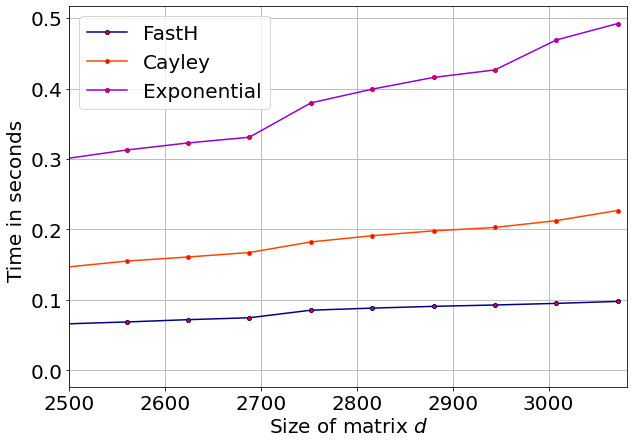

In [84]:
  
"""
    Produces small version of Figure 3 from https://arxiv.org/pdf/2009.13977
    Differences.
    - To allow fast experiment we have repeats=10 and d<1024+1. To run full experiment change lines 25+26 and 32+33. 
      Without these changes the standard deviations are a bit larger. You will also need to change xlim in plotting code 'plot.py'. 
    - The plot in the article uses sequential/parallel algorithm from https://github.com/zhangjiong724/
      Their code is not documented at all, it took us a week to get the code running on our machine. 
      To allow our code to be easily run, we chose not to use their code in the public version of our experiment. 
      Instead, we use a PyTorch implementation of the sequential algorithm and do not include the parallel algorithm.  
      This may cause some differences in the timing of the sequential algorithm relative to the article. 
"""

import numpy as np
import torch
import sys
import os 

from run_svd import run_svd, run_seq
from run_exp import run_exp, run_cay

#repeats = 100 
repeats = 10
bs   	= 32 

data = np.zeros((48, 5, repeats)) 
print("| %-10s | %-10s | %-10s | %-10s | %-10s |"%("dimension", "FastH", "Exp", "Cayley", "Sequential"))

for i, d in enumerate(range(64, 64*48+1, 64)): 
#for i, d in enumerate(range(64, 1024*2+1, 64)): 
#for i, d in enumerate(range(64, 512+1, 64)): 
	svd = run_svd(d, bs, repeats)
	exp = run_exp(d, bs, repeats)
	cay = run_cay(d, bs, repeats)
	if d <= 512: seq = run_seq(d, bs, repeats)

	data[i, 0, :] = svd
	data[i, 1, :] = exp
	data[i, 2, :] = cay
	if d <= 512: data[i, 3, :] = seq # this takes too long for d>512. 

	print("| %-10i | %-10f | %-10f | %-10f | %-10f |"%(d, data[i, 0, :].mean(), data[i, 1, :].mean(), data[i, 2, :].mean(), data[i, 3, :].mean()))
	np.savez("data", data)
 
# blue    = "C0"
# orange  = "C1"
# green   = "C2"
# red     = "C3"
# purple  = "C4"

fig, ax = plt.subplots(1, 1, figsize=(10, 7))
xs      = np.array(range(64, 4096 + 1, 64))
data    = np.load("data.npz")['arr_0']

def plot(data, name, limit=48, color=None):
    if data.shape[0] < limit: limit = data.shape[0]
    mean = np.mean(data[:limit], 1)
    if name == 'Sequential':
        plt.plot(xs[:8], mean[:8], '-', label=name, color=color, marker='o', markerfacecolor='red', markersize=4)
    else:
        plt.plot(xs[:limit], mean, '-', label=name, color=color, marker='o', markerfacecolor='red', markersize=4)
    #plt.fill_between(xs[:limit], mean - np.std(data[:limit], 1), mean + np.std(data[:limit], 1), alpha=0.3, linewidth=0, color=color)

plot(data[:, 0], "FastH",            color='darkblue')
#plot(data[:, 3], "Sequential", limit=512,   color='darkgreen')
plot(data[:, 2], "Cayley",                  color='orangered')
plot(data[:, 1], "Exponential",             color='darkviolet')

plt.legend(fontsize=20)

plt.xlabel("Size of matrix $d$", fontsize=20)
plt.ylabel("Time in seconds ", fontsize=20)

plt.xlim([2500, 64*48+10])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid()
plt.savefig('fasth_vs_exp_cay.png')
#plt.tight_layout()
#plt.savefig("running_time.png")
#plt.show()

| dimension  | FastH      | Exp        | Cayley     | Sequential |
| 64         | 0.001111   | 0.006407   | 0.004635   | 0.014719   |
| 128        | 0.002019   | 0.006913   | 0.005208   | 0.030113   |
| 192        | 0.004509   | 0.010948   | 0.009440   | 0.047286   |
| 256        | 0.005068   | 0.011734   | 0.010163   | 0.060452   |
| 320        | 0.005007   | 0.013238   | 0.011113   | 0.079619   |
| 384        | 0.005493   | 0.013752   | 0.012036   | 0.091075   |
| 448        | 0.006230   | 0.016004   | 0.013403   | 0.105581   |
| 512        | 0.006789   | 0.017420   | 0.015199   | 0.122283   |
| 576        | 0.007476   | 0.019064   | 0.016852   | 0.139090   |
| 640        | 0.008102   | 0.021425   | 0.018015   | 0.151007   |
| 704        | 0.009157   | 0.026089   | 0.020256   | 0.165319   |
| 768        | 0.010572   | 0.028037   | 0.021763   | 0.181847   |
| 832        | 0.011661   | 0.031802   | 0.024903   | 0.200375   |
| 896        | 0.012769   | 0.034699   | 0.027159   | 0.214787

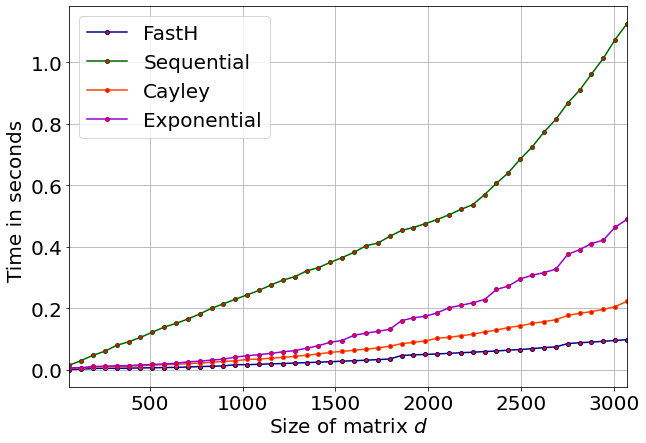

In [89]:
import numpy as np
import torch
import sys
import os 

from run_svd import run_svd, run_seq
from run_exp import run_exp, run_cay

#repeats = 100 
repeats = 10
bs   	= 32 

data = np.zeros((48, 5, repeats)) 
print("| %-10s | %-10s | %-10s | %-10s | %-10s |"%("dimension", "FastH", "Exp", "Cayley", "Sequential"))

for i, d in enumerate(range(64, 64*48+1, 64)): 
#for i, d in enumerate(range(64, 1024*2+1, 64)): 
#for i, d in enumerate(range(64, 512+1, 64)): 
	svd = run_svd(d, bs, repeats)
	exp = run_exp(d, bs, repeats)
	cay = run_cay(d, bs, repeats)
	seq = run_seq(d, bs, repeats)

	data[i, 0, :] = svd
	data[i, 1, :] = exp
	data[i, 2, :] = cay
	data[i, 3, :] = seq # this takes too long for d>512. 

	print("| %-10i | %-10f | %-10f | %-10f | %-10f |"%(d, data[i, 0, :].mean(), data[i, 1, :].mean(), data[i, 2, :].mean(), data[i, 3, :].mean()))
	np.savez("data", data)

fig, ax = plt.subplots(1, 1, figsize=(10, 7))
xs      = np.array(range(64, 4096 + 1, 64))
data    = np.load("data.npz")['arr_0']

def plot(data, name, limit=48, color=None):
    if data.shape[0] < limit: limit = data.shape[0]
    mean = np.mean(data[:limit], 1)
    plt.plot(xs[:limit], mean, '-', label=name, color=color, marker='o', markerfacecolor='red', markersize=4)

plot(data[:, 0], "FastH",            color='darkblue')
plot(data[:, 3], "Sequential", limit=512,   color='darkgreen')
plot(data[:, 2], "Cayley",                  color='orangered')
plot(data[:, 1], "Exponential",             color='darkviolet')

plt.legend(fontsize=20)

plt.xlabel("Size of matrix $d$", fontsize=20)
plt.ylabel("Time in seconds ", fontsize=20)

plt.xlim([64, 64*48+1])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid()
plt.savefig('experiment_4_1.png')


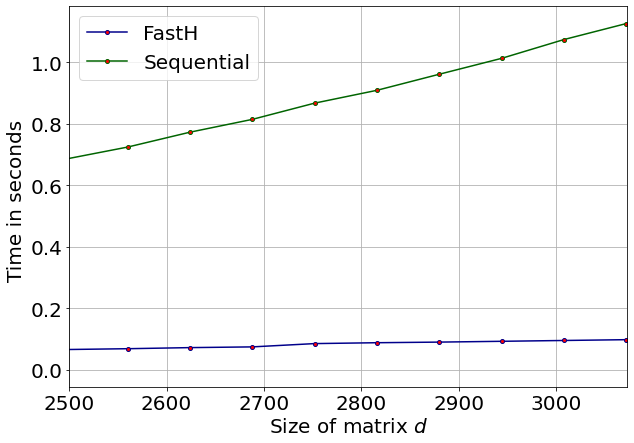

In [91]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
xs      = np.array(range(64, 4096 + 1, 64))
data    = np.load("data.npz")['arr_0']

def plot(data, name, limit=48, color=None):
    if data.shape[0] < limit: limit = data.shape[0]
    mean = np.mean(data[:limit], 1)
    plt.plot(xs[:limit], mean, '-', label=name, color=color, marker='o', markerfacecolor='red', markersize=4)
    #plt.fill_between(xs[:limit], mean - np.std(data[:limit], 1), mean + np.std(data[:limit], 1), alpha=0.3, linewidth=0, color=color)

plot(data[:, 0], "FastH",            color='darkblue')
plot(data[:, 3], "Sequential", limit=512,   color='darkgreen')
#plot(data[:, 2], "Cayley",                  color='orangered')
#plot(data[:, 1], "Exponential",             color='darkviolet')

plt.legend(fontsize=20)

plt.xlabel("Size of matrix $d$", fontsize=20)
plt.ylabel("Time in seconds ", fontsize=20)

plt.xlim([2500, 64*48+1])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid()
plt.savefig('fasth_vs_seq.png')

In [2]:
% cd ../

/


In [176]:
import torch
from fasth_wrapper import Orthogonal 

class LinearSVD(torch.nn.Module): 
	def __init__(self, d, m=32): 
		super(LinearSVD, self).__init__()
		self.d		  = d

		self.U = Orthogonal(d, m)
		self.D = torch.empty(d, 1).uniform_(0.99, 1.01)
		self.V = Orthogonal(d, m)

	def forward(self, X):
		X = self.U(X)
		X = self.D * X 
		X = self.V(X)
		return X 

bs = 32
d  = 512
neuralSVD = LinearSVD(d=d)
neuralSVD.forward(torch.zeros(d, bs).normal_())

tensor([[-1.4030e+00, -1.9197e-01,  7.1931e-01,  ..., -7.1943e-01,
          1.4849e+00,  9.3054e-01],
        [ 2.9372e-01,  1.9869e+00, -6.0776e-01,  ..., -6.3869e-01,
          5.2443e-01,  1.0302e+00],
        [ 4.5352e-01,  2.5051e-01,  8.5816e-01,  ..., -1.5345e-01,
         -7.3042e-01, -4.6569e-01],
        ...,
        [ 6.0831e-01,  1.2241e+00,  1.8039e-03,  ...,  2.1316e-01,
         -1.3790e+00, -7.8412e-01],
        [-1.2541e+00, -3.5326e-01, -1.5715e+00,  ..., -6.5762e-01,
         -4.6135e-01, -1.6394e+00],
        [-1.9254e-01,  8.2112e-01, -1.9171e+00,  ...,  7.7730e-01,
          5.6272e-01, -1.2980e+00]], grad_fn=<HouseProdBackward>)

In [38]:
import torch
m = torch.nn.Linear(20, 30)
input = torch.randn(128, 20)
output = m(input)
print(output.size())

torch.Size([128, 30])
